=== Cálculo de posición solar ===


Día del año (1-365) o fecha (YYYY-MM-DD):  2025-09-05
Latitud en grados (positiva Norte, negativa Sur):  18.55
Longitud en grados (positiva Este, negativa Oeste):  -99
Zona horaria (ej. -6 para México):  -6
Horario de verano (S/N):  N
Horas (ej. '6:18:0.5' o 'all'):  all



--- Resultados ---
Declinación solar (δ): 6.18°
Ecuación del tiempo (Et): 2.01 min
Corrección de tiempo (TC): -33.99 min

Tabla de posición solar:


,Hora estándar,Hora solar,Ángulo horario,Altura,Azimut
0,0.0,-0.566513,-188.497699,-63.886042,160.502432
1,1.0,0.433487,-173.497699,-64.449390,164.868812
2,2.0,1.433487,-158.497699,-57.423165,137.406355
3,3.0,2.433487,-143.497699,-46.333755,121.071108
4,4.0,3.433487,-128.497699,-33.534992,111.019945
5,5.0,4.433487,-113.497699,-19.970418,104.052683
6,6.0,5.433487,-98.497699,-6.027952,98.607943
7,7.0,6.433487,-83.497699,8.105669,93.839414
8,8.0,7.433487,-68.497699,22.317467,89.143940
9,9.0,8.433487,-53.497699,36.507906,83.855459


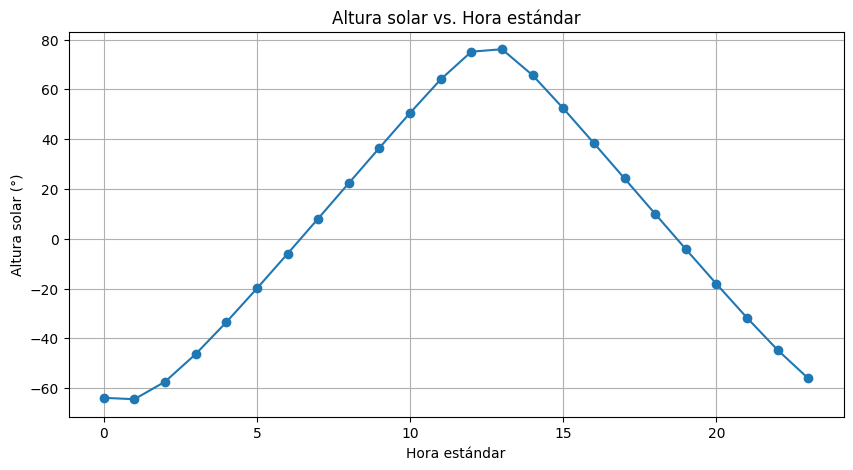

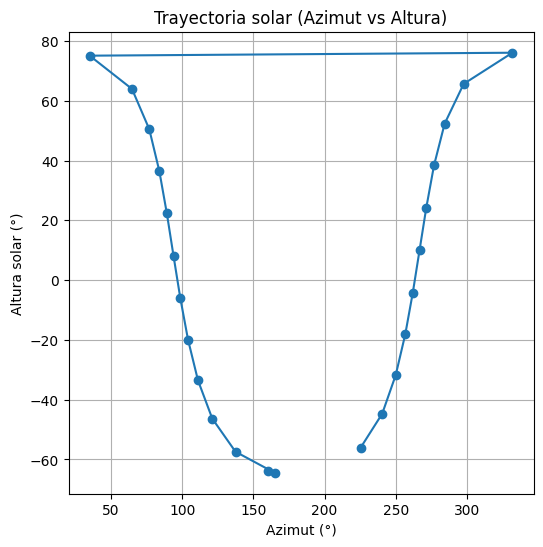

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# ---------------- utilidades ----------------
def deg2rad(d): return np.deg2rad(d)
def rad2deg(r): return np.rad2deg(r)

def parse_day_or_date(s):
    s = s.strip()
    try:
        N = int(s)
        if 1 <= N <= 366:
            return N
    except:
        pass
    try:
        dt = datetime.strptime(s, "%Y-%m-%d")
        return dt.timetuple().tm_yday
    except:
        raise ValueError("Entrada inválida. Escribe un número (1-365) o fecha YYYY-MM-DD.")

def parse_times_vector(s):
    s = s.strip()
    if not s or s.lower() in ("full","all"):
        return np.arange(0.0, 24.0, 1.0)
    if ":" in s and s.count(":") >= 2:
        parts = s.split(":")
        start, end, step = float(parts[0]), float(parts[1]), float(parts[2])
        return np.arange(start, end + 1e-9, step)
    if "," in s:
        return np.array([float(p) for p in s.split(",")], dtype=float)
    return np.array([float(s)], dtype=float)

def hours_to_hhmm(h):
    if h is None: return "--:--"
    hh = int(math.floor(h % 24))
    mm = int(round(((h % 24) - hh) * 60))
    return f"{hh:02d}:{mm:02d}"

# ---------------- cálculo solar ----------------
def solar_position(N, lat, lon, tz, dst, hours):
    lat_rad = deg2rad(lat)

    # Declinación solar
    delta = 23.45 * math.sin(deg2rad(360 * (284 + N) / 365))
    delta_rad = deg2rad(delta)

    # Ecuación del tiempo
    B = 360 * (N - 81) / 364
    E = 9.87 * math.sin(deg2rad(2*B)) - 7.53 * math.cos(deg2rad(B)) - 1.5 * math.sin(deg2rad(B))

    # Corrección de hora solar
    L_st = 15 * tz
    TC = 4 * (lon - L_st) + E

    results = []
    for h in hours:
        LST = h + (dst * 1)
        LST_corr = LST + TC/60
        HRA = 15 * (LST_corr - 12)

        HRA_rad = deg2rad(HRA)
        # Altura solar
        sin_alpha = math.sin(lat_rad)*math.sin(delta_rad) + math.cos(lat_rad)*math.cos(delta_rad)*math.cos(HRA_rad)
        alpha = math.asin(max(-1, min(1, sin_alpha)))
        altura = rad2deg(alpha)

        # Azimut solar
        cos_A = (math.sin(delta_rad) - math.sin(lat_rad)*math.sin(alpha)) / (math.cos(lat_rad)*math.cos(alpha) + 1e-10)
        cos_A = max(-1, min(1, cos_A))
        A = math.acos(cos_A)
        if HRA > 0:
            azimut = rad2deg(A) + 180
        else:
            azimut = 540 - rad2deg(A)
        azimut = azimut % 360

        results.append([h, LST_corr, HRA, altura, azimut])

    df = pd.DataFrame(results, columns=["Hora estándar","Hora solar","Ángulo horario","Altura","Azimut"])
    return df, delta, E, TC

# ---------------- interacción ----------------
print("=== Cálculo de posición solar ===")

N_input = input("Día del año (1-365) o fecha (YYYY-MM-DD): ")
N = parse_day_or_date(N_input)

lat = float(input("Latitud en grados (positiva Norte, negativa Sur): "))
lon = float(input("Longitud en grados (positiva Este, negativa Oeste): "))
tz = int(input("Zona horaria (ej. -6 para México): "))
dst_input = input("Horario de verano (S/N): ").strip().upper()
dst = 1 if dst_input == "S" else 0

times_input = input("Horas (ej. '6:18:0.5' o 'all'): ")
hours = parse_times_vector(times_input)

# ---------------- cálculo ----------------
df, delta, E, TC = solar_position(N, lat, lon, tz, dst, hours)

print("\n--- Resultados ---")
print(f"Declinación solar (δ): {delta:.2f}°")
print(f"Ecuación del tiempo (Et): {E:.2f} min")
print(f"Corrección de tiempo (TC): {TC:.2f} min")

print("\nTabla de posición solar:")
display(df)

# ---------------- gráficas ----------------
plt.figure(figsize=(10,5))
plt.plot(df["Hora estándar"], df["Altura"], marker="o")
plt.xlabel("Hora estándar")
plt.ylabel("Altura solar (°)")
plt.title("Altura solar vs. Hora estándar")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(df["Azimut"], df["Altura"], marker="o")
plt.xlabel("Azimut (°)")
plt.ylabel("Altura solar (°)")
plt.title("Trayectoria solar (Azimut vs Altura)")
plt.grid(True)
plt.show()
